# Naive Deep Q-learning

This notebook implements a naive deep Q-learning algorithm in combination with a neural network. The neural network's objective is to approximate the optimal Q-value for each state-action pair in our environment. We use a neural network with two linear layers that take a low-level representation of the environment as input and output the Q-values, corresponding to the actions an agent can take from that state. This naive deep Q-learning algorithm's overall goal is to serve as a benchmark for further improvement, and thus hyperparameter tuning will not be considered in this section. 

We test our algorithms using the **cart-and-pole** environment from the OpenAI Gym environment, where our goal is to balance a flagpole on a cart as long as possible. A reward of + 1 is given to the agent for every timestep that the pole remains upright. The goal of the agent to maximize the discounted reward over a continuous-time span. 

**References:**
- https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
- https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/tree/master/naive_deep_q_learning
- https://gym.openai.com/envs/CartPole-v0/

## Import Libraries

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

import gym
import random
import numpy as np

from ipynb.fs.full.Plotting import *
import matplotlib.pyplot as plt

In [2]:
random.seed(2021)

## Naive Deep Q-network

In [3]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, observation_space, action_space, learning_rate):
        super(LinearDeepQNetwork, self).__init__()
        
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        
        self.fc1 = nn.Linear(*self.observation_space, 128)
        self.fc2 = nn.Linear(128, self.action_space)
        
        self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.loss = nn.MSELoss()
        self.to(self.device)
        
    def forward(self, observation):
        layer1 = F.relu(self.fc1(observation))
        actions = self.fc2(layer1)
        
        return actions  

## Reinforcement Learning Agent

In [4]:
class Agent():
    def __init__(self, observation_space, action_space, learning_rate = 0.001, discount_rate = 0.99, exploration_rate = 1.0,
                 max_exploration_rate = 1, min_exploration_rate = 0.01,  exploration_decay_rate = 0.001):
        
        self.episode = 0
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        
        self.exploration_rate = exploration_rate
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        
        self.policy_network = LinearDeepQNetwork(self.observation_space, self.action_space, self.learning_rate)
        
    def choice_action(self, observation):
        exploration_rate_threshold = np.random.random()
        if exploration_rate_threshold > self.exploration_rate:
            observation = T.tensor(observation, dtype = T.float).to(self.policy_network.device)
            actions = self.policy_network.forward(observation) # Q-values for action in state.
            action = T.argmax(actions).item() # Best Q-value for action in state.
        else:
            action = np.random.choice(self.action_space) # Random action.
            
        return action
    
    def decrease_exploration_rate(self):
        self.exploration_rate = self.min_exploration_rate + \
            (self.max_exploration_rate - self.min_exploration_rate) * np.exp(- self.exploration_decay_rate * self.episode)
        self.episode += 1

    def learn(self, observation, action, reward, next_observation):
        # Set gradient to zero.
        self.policy_network.optimizer.zero_grad()
        
        # Convert to tensors.
        observation = T.tensor(observation, dtype = T.float).to(self.policy_network.device)
        action = T.tensor(action).to(self.policy_network.device)
        reward = T.tensor(reward).to(self.policy_network.device)
        next_observation = T.tensor(next_observation, dtype = T.float).to(self.policy_network.device)
        
        # Calculate loss using Bellman equation.
        q_pred = self.policy_network.forward(observation)[action]
        q_next = self.policy_network.forward(next_observation).max()
        q_target = reward + self.exploration_rate * q_next
        loss = self.policy_network.loss(q_target, q_pred).to(self.policy_network.device)
        
        # Optimizer in action.
        loss.backward()
        self.policy_network.optimizer.step()

## Main Program

In [5]:
step = 0
episodes = 10000

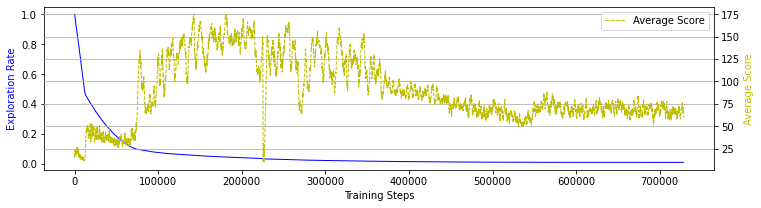

In [6]:
env = gym.make('CartPole-v0')

observation_space = env.observation_space.shape
action_space = env.action_space.n
agent = Agent(observation_space,  action_space)

scores, exploration_rate_history, steps = [], [], []

for i in range(episodes):
    observation = env.reset()
    done = False
    score = 0.0
    
    while not done:
        action = agent.choice_action(observation)
        next_observation, reward, done, _ = env.step(action)
        agent.learn(observation, action, reward, next_observation)
        observation = next_observation
        score += reward
        step += 1
        
    scores.append(score)
    steps.append(step)
    exploration_rate_history.append(agent.exploration_rate)
    agent.decrease_exploration_rate()    

plot_learning_curve(steps, scores, exploration_rate_history)